# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Behavior" data-toc-modified-id="Behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Behavior</a></div><div class="lev1 toc-item"><a href="#Pre-epoching" data-toc-modified-id="Pre-epoching-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-epoching</a></div>

In [2]:
import os
os.chdir('../../')

In [5]:
from itertools import product

from spikelearn.models import shuffle_val_predict
from spikelearn.data import io, SHORTCUTS, to_feature_array, select

# For decoding
tmin = 1.5;
tmax = 10;
DSETS = ['medium_smoothed', 'medium_smoothed_norm']
CLFs = [LogisticRegression, GaussianNB]

ntrials_init_vs_after = 50

In [3]:
from spikelearn.data import io
from scipy.io import loadmat

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

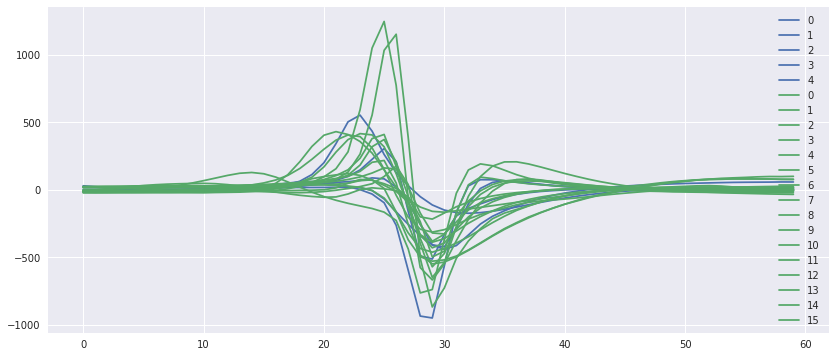

In [80]:
spk = io.load('ELI 5', 'spikes').set_index('area').waveforms

ax = plt.subplot(1,1,1)
pd.DataFrame(np.vstack(spk['PFC'].tolist())).transpose().plot(figsize=(14,6), color='b', ax=ax)
pd.DataFrame(np.vstack(spk['STR'].tolist())).transpose().plot(figsize=(14,6), color='g', ax=ax)

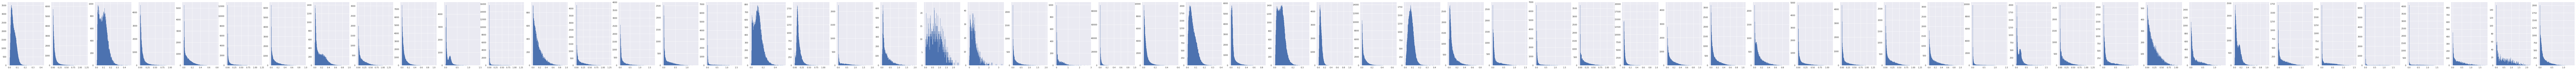

In [436]:
n_units = len(spikes[1].ravel())

plt.figure(figsize=(4*n_units,6))
for i in range(n_units):
    plt.subplot(1,n_units,i+1)
    plt.hist(np.log10(np.diff(spikes[1].squeeze()[i].reshape(-1))), 200);

---

# Pre-epoching

We want the data in the following format, so that it will enter the pipeline in early stages

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [7]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
mm= MinMaxScaler()
clf = Pipeline([('mm', mm), ('clf', LogisticRegression())])

In [54]:
data = io.load('ELI 4', 'wide_smoothed')

In [35]:
data = select(data, _min_duration=tmin, _max_duration=tmax, _mineq_quality=1)

dataPFC = select(data, area='PFC')
dataSTR = select(data, area='STR')

trials = data.reset_index().trial.unique()

#sep = trials[ntrials_init_vs_after]

In [18]:
data

full  \
trial unit                                                      
8     0     [0.634949961066, 0.999127676647, 0.93650355429...   
      1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011...   
      2     [0.0, 0.0, 0.00870670030881, 0.0819619587596, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.00198287936641, 0.03960...   
      4     [0.0824751982497, 0.271850118174, 0.4977878226...   
      6     [3.21228804466, 3.64124268137, 3.75687885845, ...   
      7     [0.0550497280331, 0.279741800744, 0.6784781051...   
      8     [5.2828466436e-05, 0.0227443450228, 0.13668111...   
      9     [0.00813100180586, 0.073153147257, 0.258580673...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [1.78494121753, 1.20632711713, 0.942240789048,...   
      13    [2.14887446267, 1.72418754252, 1.22143680693, ...   
      14    [0.360191362201, 0.615089170496, 0.64896391232...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0180466444253...   
15    0     [0.00040846771607, 0.0260883272771, 0.15320996...   
      1     [1.11520269237, 0.827651331433, 0.700491775871...   
      2     [1.12990325923, 1.1419972443, 1.55506290669, 1...   
      3     [0.0158976768819, 0.104289937932, 0.3033677320...   
      4     [0.0, 0.0, 0.00632618202125, 0.0689398153948, ...   
      6     [2.00317037301, 1.48805373934, 0.890802632606,...   
      7     [3.23771966064, 2.05651421953, 0.905720420372,...   
      8     [0.00610079995145, 0.0632281144817, 0.24074162...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [0.172932035592, 0.375216730639, 0.53144650738...   
      13    [1.06329083649, 1.06682103479, 1.31593315071, ...   
      14    [1.11479071111, 1.28716469333, 1.24597873408, ...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
23    0     [1.13128645809, 1.68825050396, 1.46290039995, ...   
      1     [0.0, 0.00260211480968, 0.0481886171065, 0.259...   
...                                                       ...   
533   14    [1.632063091, 0.854505177975, 0.253214433984, ...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
535   0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0076611030208...   
      1     [0.0589381490301, 0.28519418108, 0.67068676172...   
      2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      4     [0.0, 0.0, 0.00288014150799, 0.0465132233111, ...   
      6     [0.553328110899, 0.466811382853, 0.50163412835...   
      7     [1.36191722718, 1.03935558224, 0.53553205167, ...   
      8     [0.816571213685, 0.660907345924, 0.38001933401...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      10    [0.0, 0.0, 0.00188836466921, 0.0388057795651, ...   
      12    [1.50001542979, 1.82797005468, 1.35325902799, ...   
      13    [1.67148834852, 0.967553310046, 0.57102278955,...   
      14    [0.249468616532, 0.396254201943, 0.31004254066...   
      15    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
538   0     [0.467133461154, 0.671872138954, 0.60754850531...   
      1     [0.0, 0.000404427478712, 0.0253788659393, 0.16...   
      2     [1.696184137, 0.643309132466, 0.123565288665, ...   
      3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      4     [0.530570860331, 0.584207947647, 0.69796612597...   
      6     [7.825693463, 7.66416439865, 6.73752668739, 4....   
      7     [0.137065655992, 0.323606863475, 0.37324189631...   
      8     [0.0682777713363, 0.348532320629, 0.8876591377...   
      9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
      12    [0.0, 0.0, 0.0, 0.0, 0.00143048072219, 0.03676...   
      13    [0.681348157965, 0.49445755731, 0.394039828972...   
      14    [1.4051371682, 1.0000106472, 0.566559091711, 0...   
      15    [0.0, 0.0, 0.0,

In [46]:
res = shuffle_val_predict(clf, to_feature_array(data), n_splits=100, get_weights=False)
#resPFC = shuffle_val_predict(XGBClassifier(), to_feature_array(dataPFC), n_splits=30)
#resSTR = shuffle_val_predict(LogisticRegression(C=1), to_feature_array(dataSTR), n_splits=30)

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


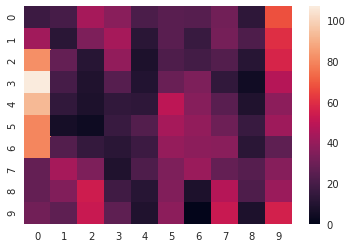

In [47]:
sns.heatmap( confusion_matrix(res.predictions.true_label,res.predictions.predictions_max))

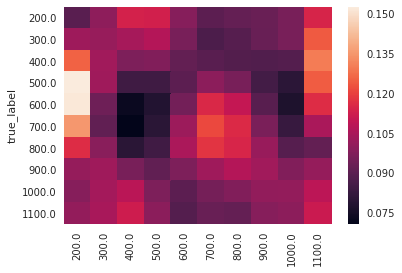

In [48]:
sns.heatmap(res.proba.groupby('true_label').mean().drop('group',axis=1))

In [52]:
res.score.mean()

score_max    -0.015384
score_mean    0.021930
dtype: float64

In [41]:
a=data.full.reset_index().groupby('unit').apply(lambda x: [np.vstack(x.full.apply(lambda x: x[:15])).mean(axis=0)])

---

In [1]:
import pickle

In [11]:
ls data/results/double_recording/LogisticRegression/narrow_smoothed_norm/ELI\ 3

both_init_vs_after.pickle  PFC_init_vs_after.pickle
performance.pickle         STR_init_vs_after.pickle


In [53]:
res = pickle.load(open('data/results/double_recording/LogisticRegression/medium_smoothed/ELI 6/both_init_vs_after.pickle', 'rb'))

In [225]:
res.score.mean()

cv              24.500000
trained_here     0.500000
n_features       5.000000
score_max        0.255058
score_mean       0.272566
dtype: float64

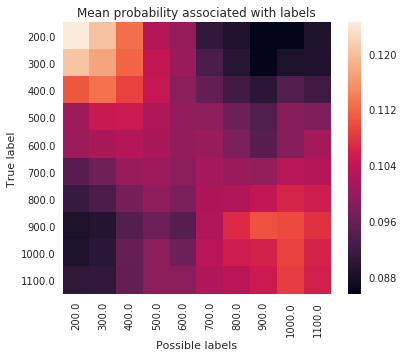

In [227]:
plt.figure(figsize=(6,5))
res.proba_matrix();

---

In [69]:
import seaborn as sns

In [57]:
from spikelearn.models import shuffle_val_predict
from spikelearn.data import io, SHORTCUTS, to_feature_array, select, remove_baseline

In [112]:
data = to_feature_array(select(io.load('DRRD 8', 'medium_smoothed'), _min_duration=1.5, is_selected=True))
mdata = data.reset_index().melt(id_vars=['trial','time'])

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


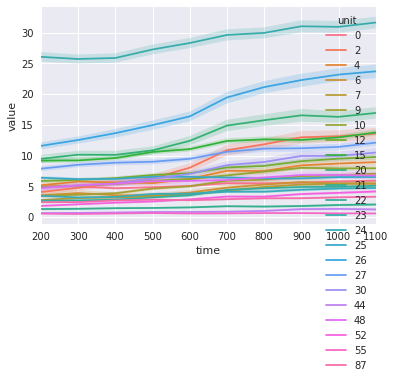

In [75]:
sns.tsplot(unit='trial', time='time', condition='unit', value='value', data=mdata)

In [100]:
mdata['after_cp'] = mdata.trial > io.load('DRRD 8', 'changepoint').gallistel[0]

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


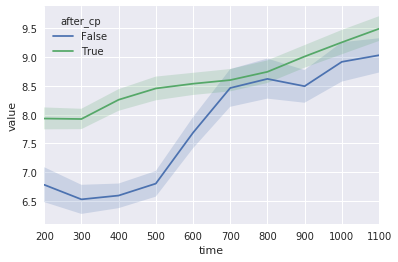

In [101]:
sns.tsplot(unit='trial', time='time', value='value', condition='after_cp', data=mdata.groupby(['time','trial']).mean().reset_index())

## Without baseline

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


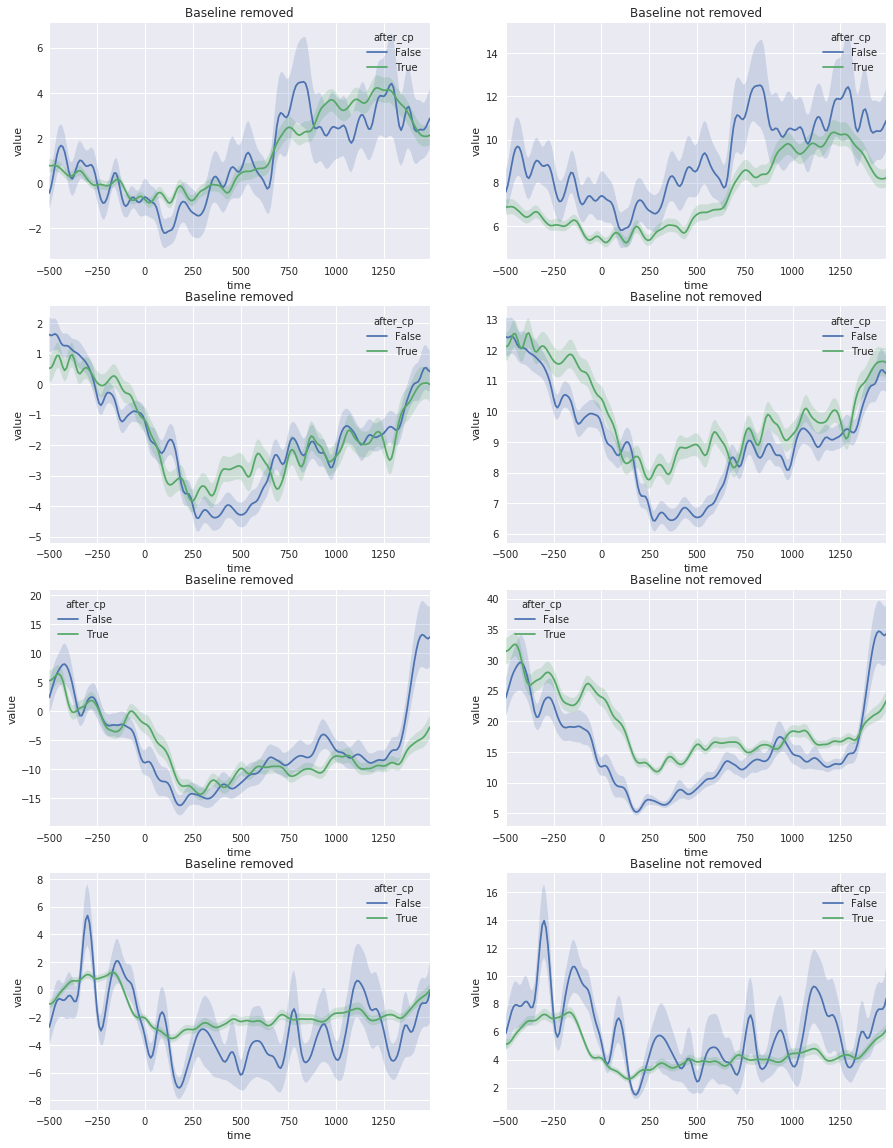

In [216]:
plt.figure(figsize=(15,20))
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    data = to_feature_array(select(io.load(label, 'narrow_smoothed_viz'), _min_duration=1.5, is_selected=True, is_tired=False), subset='full')
    nobase = remove_baseline(data, io.load(label, 'baseline'), .5)
    mdata = nobase.reset_index().melt(id_vars=['trial','time'])
    mdata['after_cp'] = mdata.trial > io.load(label, 'changepoint').gallistel[0]=
    plt.subplot(4,2, 2*i+1)
    sns.tsplot(unit='trial', time='time', value='value', condition='after_cp', data=mdata.groupby(['time','trial']).mean().reset_index())
    plt.title('Baseline removed')
    
    nobase = data
    mdata = nobase.reset_index().melt(id_vars=['trial','time'])====
    mdata['after_cp'] = mdata.trial > io.load(label, 'changepoint').gallistel[0]
    plt.subplot(4,2, 2*(i+1))
    sns.tsplot(unit='trial', time='time', value='value', condition='after_cp', data=mdata.groupby(['time','trial']).mean().reset_index())
    plt.title('Baseline not removed')

---

# Pincipal components

In [142]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)

In [171]:
data = nobase.reset_index()
data['after_cp'] = data.trial > io.load(label, 'changepoint').gallistel[0]
cp = data.groupby(['time','after_cp']).mean().reset_index().groupby('after_cp').apply(lambda df: pca.fit_transform(df.drop('trial',axis=1)))

## Calculating mean 

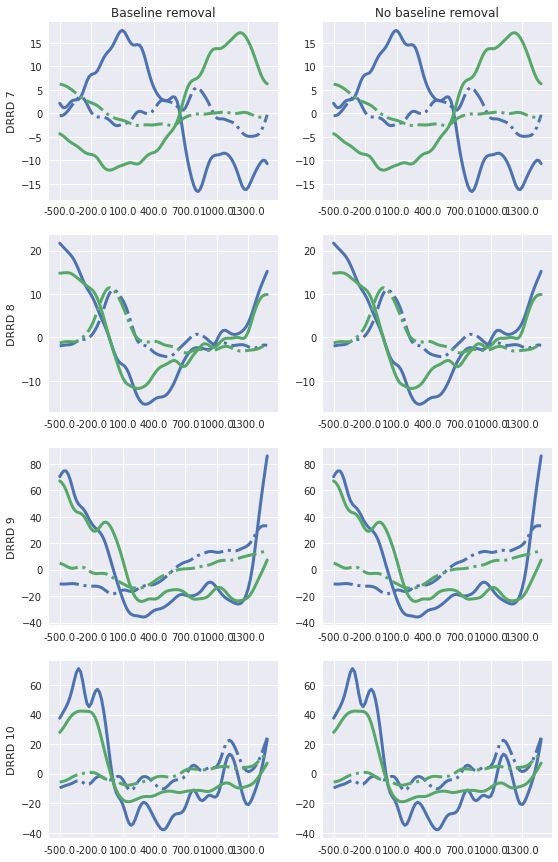

In [283]:
tick_remover = 15

plt.figure(figsize=(9,15))
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    data = to_feature_array(select(io.load(label, 'medium_smoothed_viz'), _min_duration=1.5, is_selected=True, is_tired=False), subset='full')
    nobase = remove_baseline(data, io.load(label, 'baseline'), .5)
    plt.subplot(4,2, 2*i+1)
    datap = nobase.reset_index()
    datap['after_cp'] = datap.reset_index().trial > io.load(label, 'changepoint').gallistel[0]                                     
    cp = datap.groupby(['time','after_cp']).mean().reset_index().groupby('after_cp').apply(lambda df: pca.fit_transform(df.drop(['trial','time'],axis=1)))
    plt.plot(cp[False][:,0], color='b', linestyle='-',linewidth=3)
    plt.plot(cp[False][:,1], color='b', linestyle='-.',linewidth=3)

    plt.plot(cp[True][:,0], color='g', linestyle='-',linewidth=3)
    plt.plot(cp[True][:,1], color='g', linestyle='-.',linewidth=3)
    plt.xticks(np.arange(len(data.reset_index().time.unique()))[::tick_remover], data.reset_index().time.unique()[::tick_remover])
    plt.ylabel(label); 
    if i==0: plt.title('Baseline removal')
    
    plt.subplot(4,2, 2*(i+1))
    nobase = data
    datap = nobase.reset_index()
    datap['after_cp'] = datap.trial > io.load(label, 'changepoint').gallistel[0]                                     
    cp = datap.groupby(['time','after_cp']).mean().reset_index().groupby('after_cp').apply(lambda df: pca.fit_transform(df.drop(['trial','time'],axis=1)))
    plt.plot(cp[False][:,0], color='b', linestyle='-',linewidth=3)
    plt.plot(cp[False][:,1], color='b', linestyle='-.',linewidth=3)
    if i==0: plt.title('No baseline removal')
    plt.plot(cp[True][:,0], color='g', linestyle='-',linewidth=3)
    plt.plot(cp[True][:,1], color='g', linestyle='-.',linewidth=3)
    plt.xticks(np.arange(len(data.reset_index().time.unique()))[::tick_remover], data.reset_index().time.unique()[::tick_remover])

## Trial based 

In [239]:
 cp = datap.groupby(['time','after_cp']).mean().reset_index().groupby('after_cp').apply(lambda df: pca.fit_transform(df.drop(['trial','time'],axis=1)))

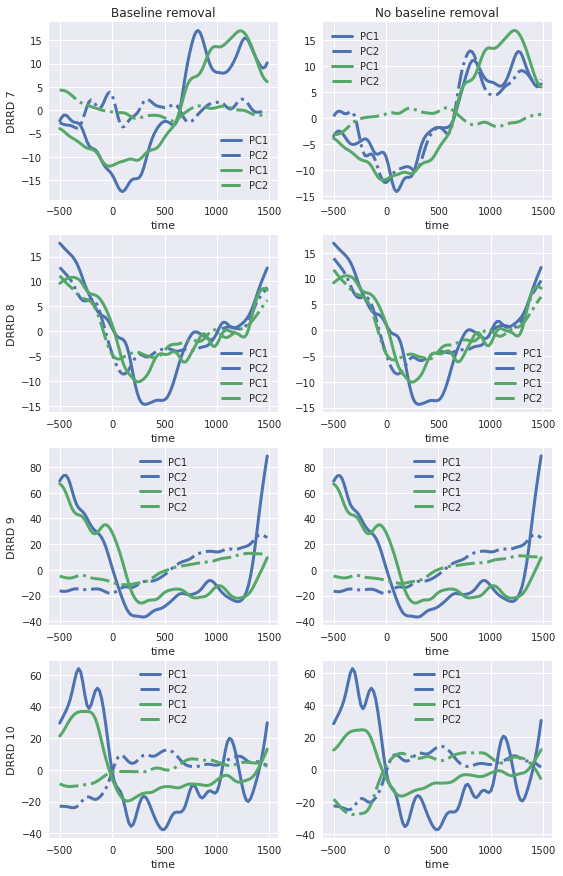

In [284]:
tick_remover = 20

plt.figure(figsize=(9,15))
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    data = to_feature_array(select(io.load(label, 'medium_smoothed_viz'), _min_duration=1.5, is_selected=True, is_tired=False), subset='full')
    nobase = remove_baseline(data, io.load(label, 'baseline'), .5)
    ax=plt.subplot(4,2, 2*i+1)
    datap = nobase.reset_index()
    datap['after_cp'] = datap.reset_index().trial > io.load(label, 'changepoint').gallistel[0]  

    pcs = pd.DataFrame(np.vstack(datap.groupby(['after_cp']).apply(lambda df: pca.fit_transform(df.drop(['trial','time'],axis=1))).values),columns=['PC1','PC2'])
    cp = pcs.join(datap[['trial','time','after_cp']]).groupby(['after_cp','time']).mean().drop('trial',axis=1)
    cp.loc[False].plot(color='b', style=['-','-.'],linewidth=3,ax=ax)

    cp.loc[True].plot(color='g', style=['-','-.'],linewidth=3,ax=ax)
    #plt.xticks(np.arange(len(data.reset_index().time.unique()))[::tick_remover], data.reset_index().time.unique()[::tick_remover])
    plt.ylabel(label); 
    if i==0: plt.title('Baseline removal')
    
    ax=plt.subplot(4,2, 2*(i+1))
    nobase = data
    datap = nobase.reset_index()
    datap['after_cp'] = datap.reset_index().trial > io.load(label, 'changepoint').gallistel[0]  

    pcs = pd.DataFrame(np.vstack(datap.groupby(['after_cp']).apply(lambda df: pca.fit_transform(df.drop(['trial','time'],axis=1))).values),columns=['PC1','PC2'])
    cp = pcs.join(datap[['trial','time','after_cp']]).groupby(['after_cp','time']).mean().drop('trial',axis=1)
    cp.loc[False].plot(color='b', style=['-','-.'], linewidth=3, ax=ax)
    if i==0: plt.title('No baseline removal')
    cp.loc[True].plot(color='g', style=['-','-.'], linewidth=3, ax=ax)
    #plt.xticks(np.arange(len(data.reset_index().time.unique()))[::tick_remover], data.reset_index().time.unique()[::tick_remover])

---

Como contar a historia:
- Enaltecer dificuldades da tarefa
    - O que ela adiciona
        - Medidas anntes e depois do aprendizado
        - Farmacologia multipla, muitos 
        
- Grafico da taxa de desparo
    - Apenas taxa media. Grafico simples estilo barra.
    - 